# Assignment 1: Polarization Detection - EDA
## SemEval 2026 Task 9, Subtask 1 (POLAR)
### CS-272: Artificial Intelligence

In [14]:
!pip install -r requirements.txt

In [25]:
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfMerger
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sajjad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Importing All Needed Libraries and checking the encoding of the Languages **

---


**Encoding for english:** Windows-1252
**Encoding for spanish:** ascii
**Encoding for german:** MacoRoman


---



In [19]:

with open("data/spa.csv", 'rb') as f:
    result = chardet.detect(f.read(100000))
result
# with open("spa.csv", 'rb') as f:   # open in binary mode (b)
#     result = chardet.detect(f.read(100000))  # read first 100k bytes
# result
# with open("spa.csv", 'rb') as f:   # open in binary mode (b)
#     result = chardet.detect(f.read(100000))  # read first 100k bytes
# result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [20]:

df_eng = pd.read_csv("data/eng.csv", encoding="Windows-1252")
# Separate English texts by label using 0 and 1
polarized_texts = df_eng[df_eng['polarization'] == 1]['text']
not_polarized_texts = df_eng[df_eng['polarization'] == 0]['text']

# Quick check
print("Number of polarized texts:", len(polarized_texts))
print("Number of not polarized texts:", len(not_polarized_texts))

Number of polarized texts: 1002
Number of not polarized texts: 1674


ENGLISH DATASET ANALYSIS

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (2676, 6)

Column data types:
id              object
text            object
polarization     int64
text_length      int64
token_length     int64
sentiment       object
dtype: object

Missing values per column:
id              0
text            0
polarization    0
text_length     0
token_length    0
sentiment       0
dtype: int64

✓ Data cleaned:
  - Original rows: 2676
  - Cleaned rows: 2676
  - Removed rows: 0

SAMPLE CLEANED DATA
                                    id  \
0  en_973938b90b0ff5d87d35a582f83f5c89   
1  en_07dfd4600426caca6e2c5883fcbea9ea   
2  en_f14519ff2302b6cd47712073f13bc461   
3  en_e48b7e7542faafa544ac57b64bc80daf   
4  en_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  polarization  \
0           is defending imperialism in the dnd chat             0   
1  Still playing with this. I am now foll

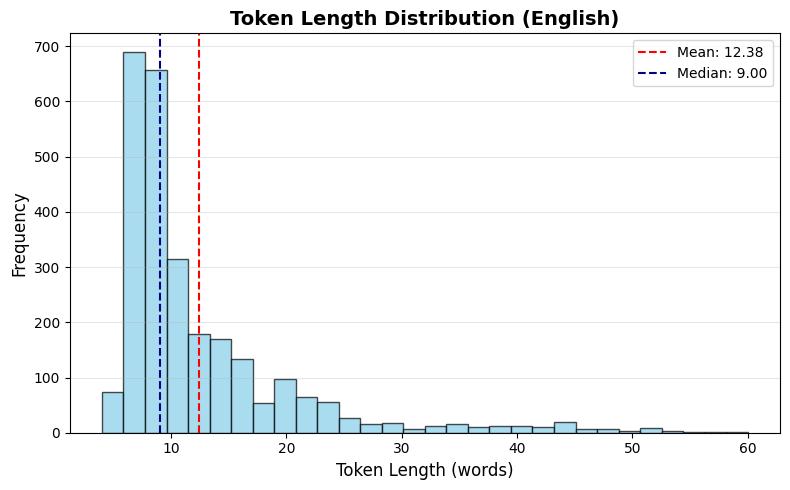


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/english/text_vs_token_length.pdf


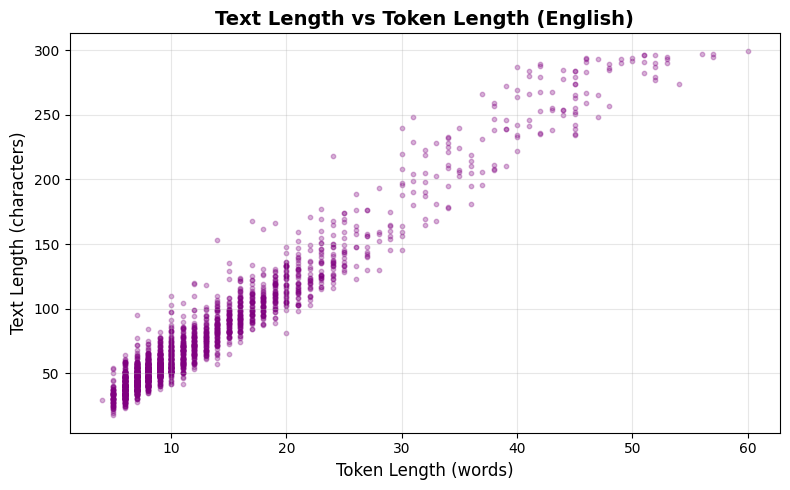


Average characters per word: 6.11
Correlation between text and token length: 0.974

TASK 3: SENTIMENT DISTRIBUTION
✓ Mapped numeric polarization to labels (0→negative, 1→positive)

Sentiment Distribution:
sentiment
negative    1674
positive    1002
Name: count, dtype: int64

Sentiment Proportions:
sentiment
negative    62.556054
positive    37.443946
Name: proportion, dtype: float64
✓ Saved: plots/english/sentiment_distribution.pdf


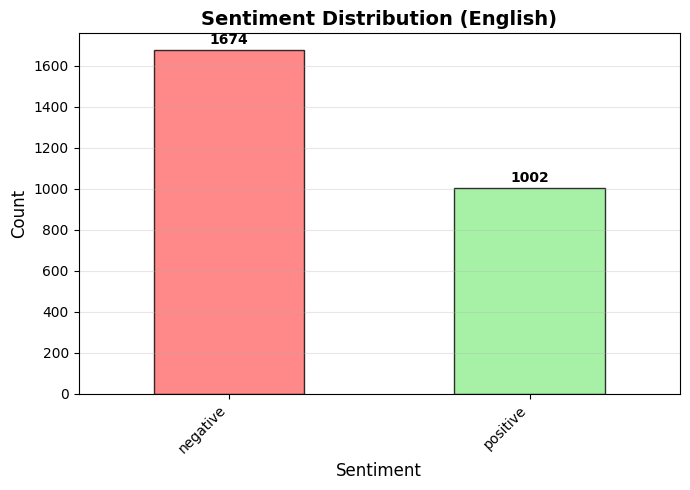


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 2676
  - Sentiment classes: 2
  - Class balance ratio: 0.60
  - Average token length: 12.38 words
  - Average text length: 75.67 characters

✓ Classes are reasonably balanced (ratio: 1.67)

ANALYSIS COMPLETE
All plots saved to: plots/english/


In [21]:
# --- English Dataset Analysis 

# Create folder for saving plots
lang = "english"
os.makedirs(f"plots/{lang}", exist_ok=True)

print("="*60)
print("ENGLISH DATASET ANALYSIS")
print("="*60)

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in eng_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(eng_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {eng_df.shape}")
print(f"\nColumn data types:")
print(eng_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(eng_df.isnull().sum())

# Store original size
original_size = len(eng_df)

# Clean the data
# 1. Remove rows with missing text or polarization
eng_df = eng_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
eng_df['text'] = eng_df['text'].astype(str).str.strip()

# 3. Remove empty strings
eng_df = eng_df[eng_df['text'] != '']
eng_df = eng_df[eng_df['text'].str.len() > 0]

# 4. Reset index after cleaning
eng_df = eng_df.reset_index(drop=True)

cleaned_size = len(eng_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(eng_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
eng_df['text_length'] = eng_df['text'].apply(len)
eng_df['token_length'] = eng_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (eng_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    eng_df = eng_df[eng_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(eng_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(eng_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = eng_df['token_length'].quantile(0.75)
q25 = eng_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = eng_df[eng_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(eng_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(eng_df['token_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (English)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(eng_df['token_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {eng_df["token_length"].mean():.2f}')
plt.axvline(eng_df['token_length'].median(), color='darkblue', linestyle='--', 
            label=f'Median: {eng_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(eng_df['token_length'], eng_df['text_length'], 
            color='purple', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (English)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = eng_df['text_length'].sum() / eng_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# Calculate and print correlation
correlation = eng_df['token_length'].corr(eng_df['text_length'])
print(f"Correlation between text and token length: {correlation:.3f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

# Map polarization to readable labels (if numeric)
if eng_df['polarization'].dtype in ['int64', 'float64']:
    sentiment_map = {0: 'negative', 1: 'positive'}
    eng_df['sentiment'] = eng_df['polarization'].map(sentiment_map)
    sentiment_col = 'sentiment'
    print("✓ Mapped numeric polarization to labels (0→negative, 1→positive)")
else:
    sentiment_col = 'polarization'
    print("✓ Using existing polarization labels")

sentiment_counts = eng_df[sentiment_col].value_counts()
print(f"\nSentiment Distribution:")
print(sentiment_counts)
print(f"\nSentiment Proportions:")
print(eng_df[sentiment_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#ff6b6b', '#90ee90']  # salmon and lightgreen
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)], 
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (English)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(eng_df)}")
print(f"  - Sentiment classes: {eng_df[sentiment_col].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {eng_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {eng_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

SPANISH DATASET ANALYSIS

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (3305, 5)

Column data types:
id              object
text            object
polarization     int64
text_length      int64
token_length     int64
dtype: object

Missing values per column:
id              0
text            0
polarization    0
text_length     0
token_length    0
dtype: int64

✓ Data cleaned:
  - Original rows: 3305
  - Cleaned rows: 3305
  - Removed rows: 0

SAMPLE CLEANED DATA
                                     id  \
0  spa_bc7bf0a1b710cd724cf96b5eeb020bff   
1  spa_688aec0f6abf4e0be44ecbfa886251cc   
2  spa_47019efabe7295c630bcc04bd0429230   
3  spa_8b4b244dbb90e0a813661ed12a1af5af   
4  spa_e2f37881da08b8d7b6eb07bc37356746   

                                                text  polarization  \
0  "bueno, tirando"\r\ny si hay repregunta, enton...             0   
1                "caimos en su retorica de indigena"             0   
2   "c

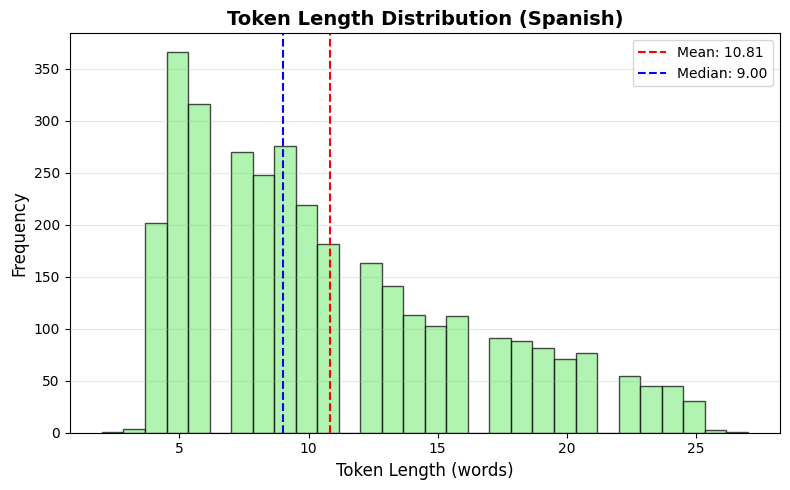


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/spanish/text_vs_token_length.pdf


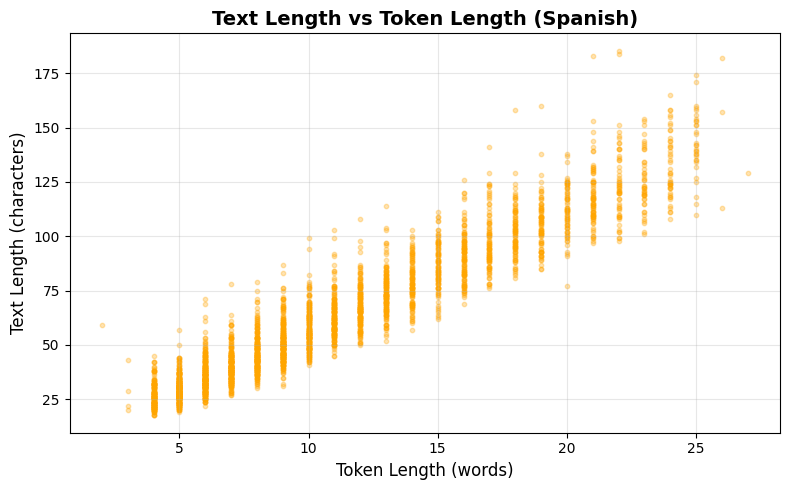


Average characters per word: 5.72

TASK 3: SENTIMENT DISTRIBUTION

Sentiment Distribution:
polarization
1    1660
0    1645
Name: count, dtype: int64

Sentiment Proportions:
polarization
1    50.226929
0    49.773071
Name: proportion, dtype: float64
✓ Saved: plots/spanish/sentiment_distribution.pdf


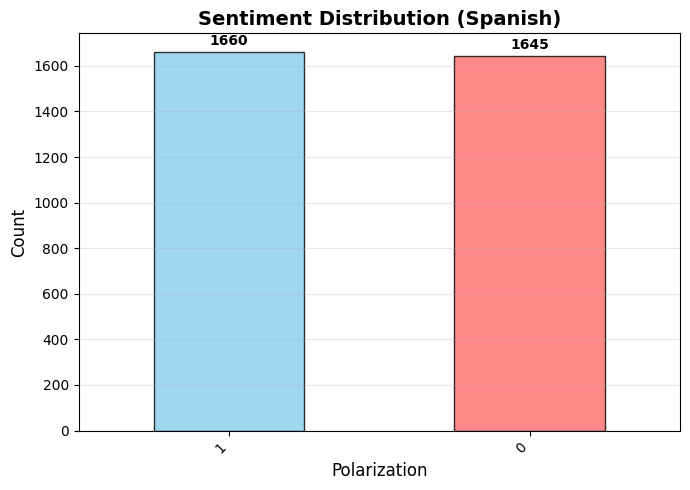


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 3305
  - Sentiment classes: 2
  - Class balance ratio: 0.99
  - Average token length: 10.81 words
  - Average text length: 61.88 characters

✓ Classes are reasonably balanced (ratio: 1.01)

ANALYSIS COMPLETE
All plots saved to: plots/spanish/


In [22]:
# --- Spanish Dataset Analysis 
# Create folder for saving plots
lang = "spanish"
os.makedirs(f"plots/{lang}", exist_ok=True)

print("="*60)
print("SPANISH DATASET ANALYSIS")
print("="*60)

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in spa_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(spa_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {spa_df.shape}")
print(f"\nColumn data types:")
print(spa_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(spa_df.isnull().sum())

# Store original size
original_size = len(spa_df)

# Clean the data
# 1. Remove rows with missing text or polarization
spa_df = spa_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
spa_df['text'] = spa_df['text'].astype(str).str.strip()

# 3. Remove empty strings
spa_df = spa_df[spa_df['text'] != '']
spa_df = spa_df[spa_df['text'].str.len() > 0]

# 4. Reset index after cleaning
spa_df = spa_df.reset_index(drop=True)

cleaned_size = len(spa_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(spa_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
spa_df['text_length'] = spa_df['text'].apply(len)
spa_df['token_length'] = spa_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (spa_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    spa_df = spa_df[spa_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(spa_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(spa_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = spa_df['token_length'].quantile(0.75)
q25 = spa_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = spa_df[spa_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(spa_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(spa_df['token_length'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(spa_df['token_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {spa_df["token_length"].mean():.2f}')
plt.axvline(spa_df['token_length'].median(), color='blue', linestyle='--', 
            label=f'Median: {spa_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(spa_df['token_length'], spa_df['text_length'], 
            color='orange', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = spa_df['text_length'].sum() / spa_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

sentiment_counts = spa_df['polarization'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nSentiment Proportions:")
print(spa_df['polarization'].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#87ceeb', '#ff6b6b', '#95d5b2']
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)], 
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Polarization', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(spa_df)}")
print(f"  - Sentiment classes: {spa_df['polarization'].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {spa_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {spa_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

GERMAN DATASET ANALYSIS
✓ Dataset loaded successfully: 3180 rows

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (3180, 3)

Column data types:
id              object
text            object
polarization     int64
dtype: object

Missing values per column:
id              0
text            0
polarization    0
dtype: int64

✓ Data cleaned:
  - Original rows: 3180
  - Cleaned rows: 3180
  - Removed rows: 0

SAMPLE CLEANED DATA
                                     id  \
0  deu_fa07b0533db91281c049fb722ca121d7   
1  deu_10e753b5d49374d2de1f68dfc1e2d249   
2  deu_61be00002367a33400dade564edccc59   
3  deu_d28b20af64d590134448fcdbfbb0f7dd   
4  deu_005fc728be211eae1c308a0fc20d73df   

                                                text  polarization  
0  Natürlich bin ich linksgrün - ich habe Herz u n d             0  
1  Schuld sind Habeck,  die grünen und diese link...             1  
2  Vielleicht ist da ja tatsächlich was dran. Höc..

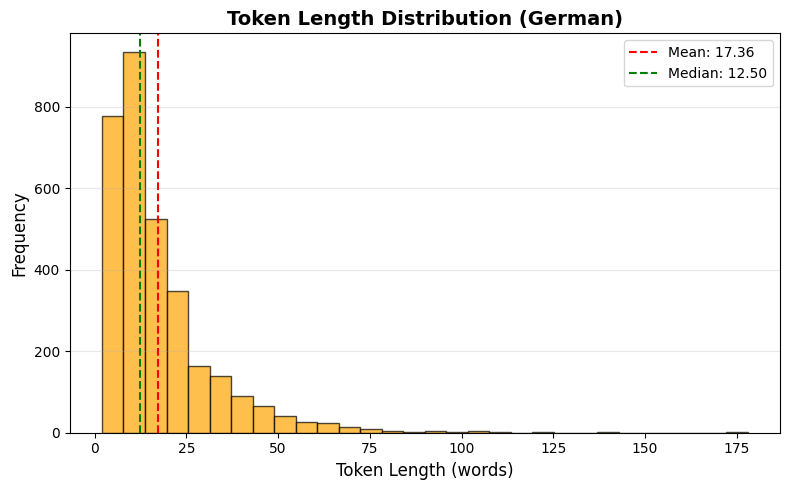


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/german/text_vs_token_length.pdf


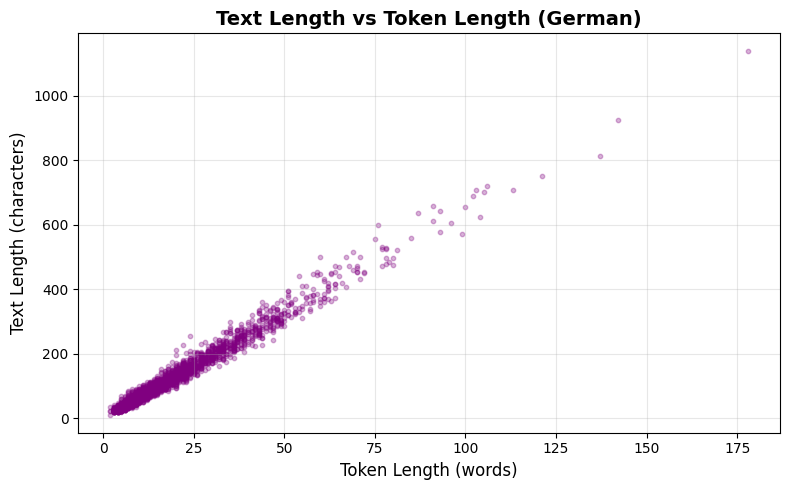


Average characters per word: 6.56

TASK 3: SENTIMENT DISTRIBUTION

Sentiment Distribution:
polarization
0    1668
1    1512
Name: count, dtype: int64

Sentiment Proportions:
polarization
0    52.45283
1    47.54717
Name: proportion, dtype: float64
✓ Saved: plots/german/sentiment_distribution.pdf


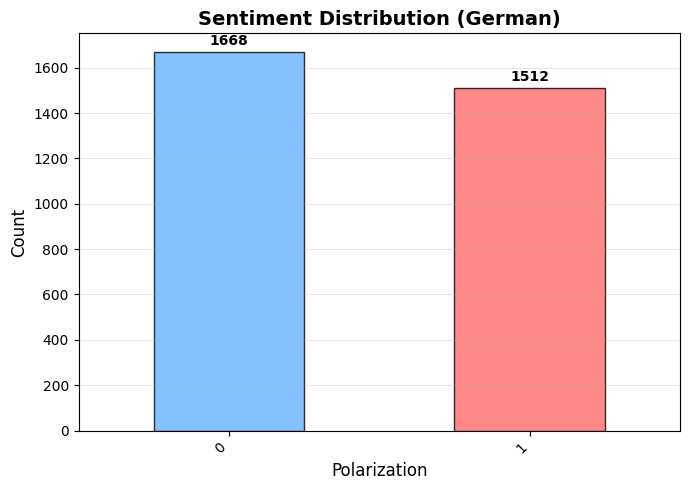


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 3180
  - Sentiment classes: 2
  - Class balance ratio: 0.91
  - Average token length: 17.36 words
  - Average text length: 113.94 characters

✓ Classes are reasonably balanced (ratio: 1.10)

ANALYSIS COMPLETE
All plots saved to: plots/german/


In [23]:
# --- German Dataset Analysis 
# Create folder for saving plots
lang = "german"
os.makedirs(f"plots/{lang}", exist_ok=True)

print("="*60)
print("GERMAN DATASET ANALYSIS")
print("="*60)

# Load German dataset
try:
    deu_df = pd.read_csv("data/deu.csv", encoding="utf-8")
    print(f"✓ Dataset loaded successfully: {len(deu_df)} rows")
except FileNotFoundError:
    print("ERROR: File 'train/deu.csv' not found!")
    exit()

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in deu_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(deu_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {deu_df.shape}")
print(f"\nColumn data types:")
print(deu_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(deu_df.isnull().sum())

# Store original size
original_size = len(deu_df)

# Clean the data
# 1. Remove rows with missing text or polarization
deu_df = deu_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
deu_df['text'] = deu_df['text'].astype(str).str.strip()

# 3. Remove empty strings
deu_df = deu_df[deu_df['text'] != '']
deu_df = deu_df[deu_df['text'].str.len() > 0]

# 4. Reset index after cleaning
deu_df = deu_df.reset_index(drop=True)

cleaned_size = len(deu_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(deu_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
deu_df['text_length'] = deu_df['text'].apply(len)
deu_df['token_length'] = deu_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (deu_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    deu_df = deu_df[deu_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(deu_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(deu_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = deu_df['token_length'].quantile(0.75)
q25 = deu_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = deu_df[deu_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(deu_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(deu_df['token_length'], bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (German)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(deu_df['token_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {deu_df["token_length"].mean():.2f}')
plt.axvline(deu_df['token_length'].median(), color='green', linestyle='--', 
            label=f'Median: {deu_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(deu_df['token_length'], deu_df['text_length'], 
            color='purple', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (German)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = deu_df['text_length'].sum() / deu_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

sentiment_counts = deu_df['polarization'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nSentiment Proportions:")
print(deu_df['polarization'].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#66b3ff', '#ff6b6b', '#95d5b2']
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)], 
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (German)', fontsize=14, fontweight='bold')
plt.xlabel('Polarization', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(deu_df)}")
print(f"  - Sentiment classes: {deu_df['polarization'].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {deu_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {deu_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

In [26]:
# --- Combined Multi-Language Dataset Analysis 
print("="*60)
print("COMBINED MULTI-LANGUAGE DATASET ANALYSIS")
print("="*60)

# Create the plots folder if it doesn't exist
os.makedirs("plots", exist_ok=True)

# --- LOAD AND COMBINE ALL DATASETS ---
print("\n" + "="*60)
print("LOADING DATASETS")
print("="*60)

datasets = []
languages = ['english', 'spanish', 'german']
file_names = {'english': 'eng.csv', 'spanish': 'spa.csv', 'german': 'deu.csv'}

for lang in languages:
    try:
        file_path = f"data/{file_names[lang]}"
        temp_df = pd.read_csv(file_path, encoding="utf-8")
        temp_df['language'] = lang
        datasets.append(temp_df)
        print(f"✓ Loaded {lang}: {len(temp_df)} rows")
    except FileNotFoundError:
        print(f"⚠ Warning: File '{file_path}' not found. Skipping {lang}.")
    except Exception as e:
        print(f"⚠ Error loading {lang}: {e}")

if not datasets:
    print("ERROR: No datasets were loaded successfully!")
    exit()

# Combine all datasets
df = pd.concat(datasets, ignore_index=True)
print(f"\n✓ Combined dataset created: {len(df)} total rows")

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization', 'language']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Store original size
original_size = len(df)

# Clean the data
# 1. Remove rows with missing text or polarization
df = df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
df['text'] = df['text'].astype(str).str.strip()

# 3. Remove empty strings
df = df[df['text'] != '']
df = df[df['text'].str.len() > 0]

# 4. Reset index after cleaning
df = df.reset_index(drop=True)

cleaned_size = len(df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# --- CALCULATE TOKEN STATISTICS ---
print("\n" + "="*60)
print("CALCULATING TOKEN STATISTICS")
print("="*60)

df['text_length'] = df['text'].apply(len)
df['token_length'] = df['text'].apply(lambda x: len(x.split()))

# Remove zero-token texts
zero_tokens = (df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: Removing {zero_tokens} texts with 0 tokens")
    df = df[df['token_length'] > 0]

# Calculate statistics per language
token_stats = df.groupby('language')['token_length'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nToken Length Statistics per Language:")
print(token_stats)

# --- MERGE INDIVIDUAL LANGUAGE PDFs ---
print("\n" + "="*60)
print("MERGING INDIVIDUAL LANGUAGE PDFs")
print("="*60)

pdf_files = []
for lang in languages:
    for plot_type in ['token_length_distribution', 'text_vs_token_length', 'sentiment_distribution']:
        pdf_path = f"plots/{lang}/{plot_type}.pdf"
        if os.path.exists(pdf_path):
            pdf_files.append(pdf_path)
        else:
            print(f"⚠ Warning: File not found: {pdf_path}")

if pdf_files:
    try:
        merger = PdfMerger()
        for pdf in pdf_files:
            merger.append(pdf)
        output_path = "plots/separate_lang_graphs.pdf"
        merger.write(output_path)
        merger.close()
        print(f"✓ Successfully merged {len(pdf_files)} PDFs into '{output_path}'")
    except Exception as e:
        print(f"⚠ Error merging PDFs: {e}")
else:
    print("⚠ No individual language PDFs found to merge")

# --- CREATE COMBINED COMPARISON PLOTS ---
print("\n" + "="*60)
print("CREATING COMBINED COMPARISON PLOTS")
print("="*60)

# Save all combined graphs to a single PDF
with PdfPages("plots/combined_graphs.pdf") as pdf:
    
    # === Plot 1: Token Length Distribution (Boxplot) ===
    print("Creating Plot 1: Token Length Boxplot...")
    plt.figure(figsize=(10, 6))
    
    # Create boxplot with better styling
    bp = df.boxplot(column="token_length", by="language", grid=False, 
                     patch_artist=True, return_type='dict')
    
    # Color the boxes
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']
    for patch, color in zip(bp['token_length']['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.suptitle("")  # Remove automatic title
    plt.title("Token Length Distribution per Language", fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Token Length (words)", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 1 saved")
    
    # === Plot 2: Average Token Length (Bar Chart) ===
    print("Creating Plot 2: Average Token Length Bar Chart...")
    plt.figure(figsize=(10, 6))
    
    ax = token_stats["mean"].plot(kind="bar", color=colors, edgecolor='black', alpha=0.8)
    plt.title("Average Token Length per Language", fontsize=14, fontweight='bold')
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Average Token Length (words)", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(token_stats["mean"]):
        ax.text(i, v + token_stats["mean"].max()*0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 2 saved")
    
    # === Plot 3: Sentiment Distribution Across Languages ===
    print("Creating Plot 3: Sentiment Distribution...")
    plt.figure(figsize=(10, 6))
    
    # Create sentiment distribution
    sentiment_dist = df.groupby(["language", "polarization"]).size().unstack(fill_value=0)
    
    ax = sentiment_dist.plot(kind="bar", stacked=True, 
                              color=['#ff6b6b', '#90ee90'], 
                              edgecolor='black', alpha=0.8)
    plt.title("Sentiment Distribution Across Languages", fontsize=14, fontweight='bold')
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title="Polarization", labels=['Negative', 'Positive'], 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 3 saved")
    
    # === Plot 4: Token Length Distribution (Histogram Overlay) ===
    print("Creating Plot 4: Token Length Histogram Comparison...")
    plt.figure(figsize=(10, 6))
    
    for lang, color in zip(languages, colors):
        lang_data = df[df['language'] == lang]['token_length']
        plt.hist(lang_data, bins=30, alpha=0.5, label=lang.capitalize(), 
                color=color, edgecolor='black')
    
    plt.title("Token Length Distribution Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Token Length (words)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 4 saved")
    
    # === Plot 5: Average Text vs Token Length per Language ===
    print("Creating Plot 5: Text vs Token Length Comparison...")
    plt.figure(figsize=(10, 6))
    
    for lang, color in zip(languages, colors):
        lang_data = df[df['language'] == lang]
        plt.scatter(lang_data['token_length'], lang_data['text_length'], 
                   alpha=0.3, label=lang.capitalize(), color=color, s=10)
    
    plt.title("Text Length vs Token Length (All Languages)", fontsize=14, fontweight='bold')
    plt.xlabel("Token Length (words)", fontsize=12)
    plt.ylabel("Text Length (characters)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 5 saved")

print("\n✓ All combined graphs saved to 'plots/combined_graphs.pdf'")

# --- SUMMARY STATISTICS ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nOverall Dataset:")
print(f"  - Total samples: {len(df)}")
print(f"  - Languages: {df['language'].nunique()}")

print(f"\nSamples per Language:")
for lang in languages:
    count = len(df[df['language'] == lang])
    pct = count / len(df) * 100
    print(f"  - {lang.capitalize()}: {count} ({pct:.1f}%)")

print(f"\nAverage Characters per Word:")
for lang in languages:
    lang_data = df[df['language'] == lang]
    avg_chars = lang_data['text_length'].sum() / lang_data['token_length'].sum()
    print(f"  - {lang.capitalize()}: {avg_chars:.2f}")

print(f"\nSentiment Balance per Language:")
for lang in languages:
    lang_data = df[df['language'] == lang]
    sentiment_counts = lang_data['polarization'].value_counts()
    if len(sentiment_counts) > 1:
        balance = sentiment_counts.min() / sentiment_counts.max()
        print(f"  - {lang.capitalize()}: {balance:.2f} (1.0 = perfect balance)")
    else:
        print(f"  - {lang.capitalize()}: Only one sentiment class present")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Output files:")
print(f"  - plots/combined_graphs.pdf (5 comparison plots)")
print(f"  - plots/separate_lang_graphs.pdf (individual language plots merged)")

COMBINED MULTI-LANGUAGE DATASET ANALYSIS

LOADING DATASETS
✓ Loaded english: 2676 rows
✓ Loaded spanish: 3305 rows
✓ Loaded german: 3180 rows

✓ Combined dataset created: 9161 total rows

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization', 'language']

✓ Data cleaned:
  - Original rows: 9161
  - Cleaned rows: 9161
  - Removed rows: 0

CALCULATING TOKEN STATISTICS

Token Length Statistics per Language:
               mean  median        std  min  max
language                                        
english   12.379297     9.0   8.447972    4   60
german    17.360692    12.5  15.094452    2  178
spanish   10.813011     9.0   5.482098    2   27

MERGING INDIVIDUAL LANGUAGE PDFs
✓ Successfully merged 9 PDFs into 'plots/separate_lang_graphs.pdf'

CREATING COMBINED COMPARISON PLOTS
Creating Plot 1: Token Length Boxplot...
✓ Plot 1 saved
Creating Plot 2: Average Token Length Bar Chart...
✓ Plot 2 saved
Creating Plot 3: Sentiment Distribution...
✓ Plot 3 saved
Creat

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>